### 修复误匹配

In [1]:
import pandas as pd
import torch
from transformers import CamembertTokenizer, CamembertModel
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 加载法语模型
nlp = spacy.load("fr_core_news_sm")

def lemmatize_text(text):
    """使用spaCy进行词形还原"""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def match_target_word(text, target_word):
    """匹配目标词，确保只匹配目标词或其复数形式"""
    doc = nlp(text)
    matches = [
        token for token in doc
        if token.lemma_ == target_word and token.pos_ in ["NOUN", "VERB", "ADJ"]
    ]
    return len(matches) > 0  # 如果找到至少一个匹配，返回True


def preprocess_and_embed(texts, ids, word, tokenizer, model, batch_size=8):
    """预处理文本并获取目标词嵌入"""
    word_embeddings = []
    review_embeddings = []
    matched_ids = []  # 新增：保存成功匹配的ID

    # 对批次进行编码
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_ids = ids[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

        # 获取每个句子中目标词的位置
        word_ids = [next((i+1 for i, token in enumerate(tokenizer.tokenize(text)) if word in token), None) for text in batch_texts]

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.last_hidden_state

            # 提取目标词的embeddings并记录索引
            for idx, word_id in enumerate(word_ids):
                if word_id is not None:
                    word_embeddings.append(hidden_states[idx, word_id].numpy())
                    review_embeddings.append({'id': batch_ids[idx], 'embedding': hidden_states[idx, word_id].numpy()})
                    matched_ids.append(batch_ids[idx])  # 新增：保存匹配的ID

    return word_embeddings, review_embeddings, matched_ids  # 修改：返回matched_ids

def visualize_embeddings(word_embeddings, review_ids):
    """使用t-SNE可视化目标词的二维嵌入"""
    word_embeddings_array = np.array(word_embeddings)

    # 检查样本数量，并调整perplexity
    n_samples = len(word_embeddings_array)
    if n_samples < 2:
        print("Not enough samples for visualization")
        return

    perplexity_value = min(30, n_samples - 1)

    # 使用t-SNE降维
    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
    reduced_embeddings = tsne.fit_transform(word_embeddings_array)

    # 绘制二维散点图
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', marker='o')

    # 确保review_ids长度与reduced_embeddings相同
    assert len(review_ids) == len(reduced_embeddings), "Mismatch between review_ids and embeddings"

    # 显示id标签
    for i, review_id in enumerate(review_ids):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], str(review_id), fontsize=8)

    plt.title("2D Visualization of Word Embeddings (t-SNE)", fontsize=15)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

def analyze_word(word, df, sample_size=100):
    """分析单个词的多义性"""
    tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
    model = CamembertModel.from_pretrained('camembert-base')
    model.eval()

    relevant_texts = df[df['review'].apply(lambda x: match_target_word(str(x), word))]
    if relevant_texts.empty:
        print(f"No occurrences found for word: {word}")
        return None

    relevant_texts = relevant_texts.sample(n=min(len(relevant_texts), sample_size), random_state=42)

    # 获取对应的id和预处理文本
    ids = relevant_texts.iloc[:, 0].values
    processed_texts = [lemmatize_text(re.sub(r'[^\w\s]', ' ', str(text).lower()).strip()) for text in relevant_texts['review']]

    word_embeddings, review_embeddings, matched_ids = preprocess_and_embed(processed_texts, ids, word, tokenizer, model)  # 修改：接收matched_ids

    if len(word_embeddings) < 2:
        print(f"Not enough valid embeddings found for word: {word}")
        return None

    # 计算余弦相似度矩阵并得到多义性分数
    embeddings_array = np.array(word_embeddings)
    norm = np.linalg.norm(embeddings_array, axis=1, keepdims=True)
    similarity_matrix = np.dot(embeddings_array / norm, (embeddings_array / norm).T)

    polysemy_score = np.std(similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)])

    # 使用匹配的ID进行可视化
    visualize_embeddings(word_embeddings, matched_ids)

    return {
        'word': word,
        'occurrences': len(word_embeddings),
        'polysemy_score': polysemy_score,
        'review_embeddings': review_embeddings
    }

def quick_polysemy_analysis(file_path, target_words, sample_size=100):
    """主分析函数"""
    df = pd.read_csv(file_path, header=None, names=['id', 'film-url', 'review', 'polarity'])

    results = []
    for word in target_words:
        print(f"\nAnalyzing word: {word}")
        analysis_result = analyze_word(word, df, sample_size)
        if analysis_result:
            results.append(analysis_result)

    for result in results:
        print(f"\nWord: {result['word']}")
        print(f"Occurrences: {result['occurrences']}")
        print(f"Polysemy score: {result['polysemy_score']:.4f}")

        # 输出每个review的目标词嵌入及其对应的id
        for review in result['review_embeddings']:
            print(f"Review ID {review['id']}: {review['embedding'][:5]}...")  # 显示嵌入的前5个数值，避免输出过长

    return results


In [2]:
# 使用示例
file_path = 'test.csv'

#### 样本总量就比较少的几个词


Analyzing word: opéra


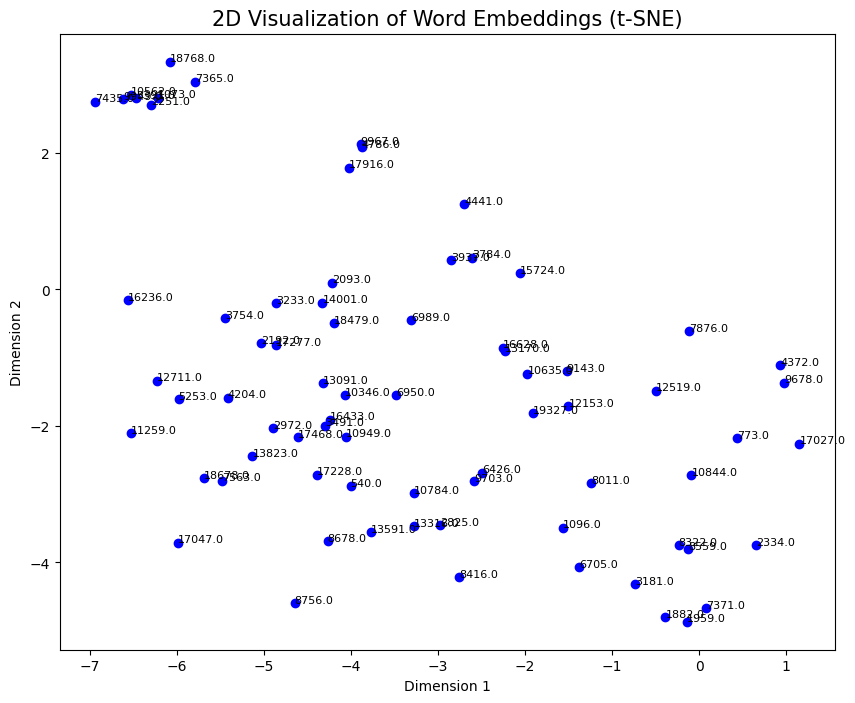


Word: opéra
Occurrences: 74
Polysemy score: 0.0955
Review ID 1882.0: [-0.06820646  0.14570238 -0.15450308 -0.23618221  0.02725147]...
Review ID 16628.0: [-0.03645595  0.1484903   0.0432201  -0.09889562 -0.02006096]...
Review ID 4204.0: [-0.02800218 -0.00507403  0.04813901 -0.03804274 -0.01073867]...
Review ID 540.0: [-0.04142451  0.09783828  0.11270279 -0.04981151 -0.12089774]...
Review ID 7365.0: [-0.06773008  0.07864711  0.07255381  0.02212908  0.03913689]...
Review ID 19327.0: [-0.06028087  0.2189767   0.0823363  -0.2128281  -0.02597933]...
Review ID 2825.0: [-0.14543357  0.12001524  0.005064   -0.15896282  0.01046072]...
Review ID 8322.0: [-0.05991033  0.15348266  0.17936856 -0.20363103  0.05039895]...
Review ID 3181.0: [-0.09535763  0.17544076  0.12118961 -0.11651599 -0.03349712]...
Review ID 13170.0: [-0.09771529  0.18285006  0.04534721 -0.17681903  0.08217809]...
Review ID 17047.0: [-0.01669521  0.1684555   0.04181477  0.00386316  0.04905041]...
Review ID 7563.0: [ 0.02031477  

In [3]:
target_words = ['opéra']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)
# 不知道为什么opéra换成采样200的时候python就会报错，
# 好像是pytorch处理的时候有什么问题


Analyzing word: avocat


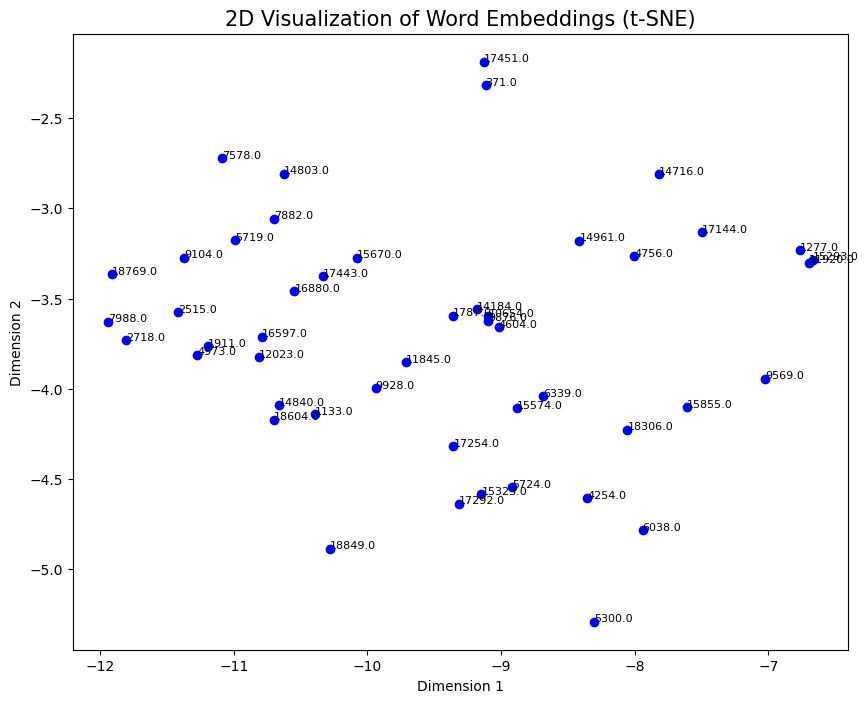


Word: avocat
Occurrences: 48
Polysemy score: 0.1092
Review ID 14184.0: [-0.09826908 -0.01388761  0.32638672  0.0317074  -0.00704017]...
Review ID 17254.0: [-0.1024994   0.09978446  0.3207519   0.05232562 -0.06888273]...
Review ID 12023.0: [ 0.07538583 -0.30020735  0.31293204  0.03114621 -0.04588264]...
Review ID 17451.0: [-0.0417942   0.00643619  0.06331705  0.05652811 -0.09933626]...
Review ID 11845.0: [-0.08503215 -0.27177355  0.3568023  -0.02847468 -0.07034312]...
Review ID 16597.0: [-0.01143073 -0.11510468  0.20736209 -0.01178841 -0.00044356]...
Review ID 5719.0: [ 0.01629641 -0.21377182  0.19448598  0.01179531 -0.06015939]...
Review ID 9104.0: [-0.01874143 -0.40792453  0.45493424 -0.02898548  0.00285208]...
Review ID 1911.0: [-0.03596506 -0.14248973  0.32324687  0.03434861 -0.07778621]...
Review ID 11920.0: [-0.0818485   0.0319718   0.07412875 -0.11508696 -0.0954679 ]...
Review ID 4604.0: [-0.06899178 -0.13499995  0.16170226 -0.03681876 -0.05528704]...
Review ID 1787.0: [-0.07026

In [4]:
target_words = ['avocat']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)


Analyzing word: bureau


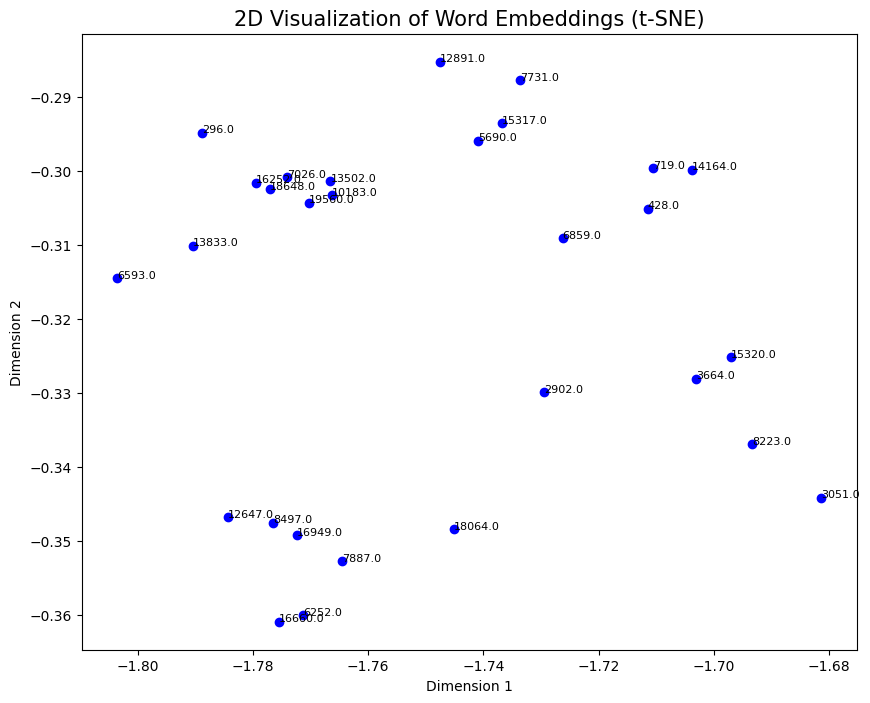


Word: bureau
Occurrences: 29
Polysemy score: 0.0657
Review ID 18648.0: [-0.0011669  -0.20100662 -0.27158886  0.07387118  0.00371986]...
Review ID 12647.0: [ 0.0152184   0.10460716  0.08660695  0.03239039 -0.00442308]...
Review ID 7887.0: [-0.04420759  0.22180554  0.10345478 -0.13295151  0.017223  ]...
Review ID 15320.0: [-0.12471712  0.02372919 -0.31154895  0.06034703 -0.05206624]...
Review ID 6593.0: [-0.02027691 -0.16817957 -0.21867345  0.11262292  0.02149447]...
Review ID 6859.0: [-0.01731844 -0.16934049 -0.09394173 -0.01031243 -0.03105767]...
Review ID 15317.0: [-0.04502966 -0.1578922  -0.11980693  0.02034242 -0.07357767]...
Review ID 296.0: [ 0.00544356 -0.0414229  -0.30741727  0.10305554  0.00846308]...
Review ID 18064.0: [ 0.03090649  0.02191349 -0.02197972 -0.01770391  0.0634707 ]...
Review ID 8223.0: [-0.04726195  0.00429238 -0.04922861 -0.01869527  0.01084007]...
Review ID 10183.0: [-0.03328045 -0.05295298 -0.1073062   0.02649246 -0.05967229]...
Review ID 7731.0: [-0.0414778

In [5]:
target_words = ['bureau']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)

#### 样本量稍多一些的词，采样数为100/200时的对比


Analyzing word: rouge


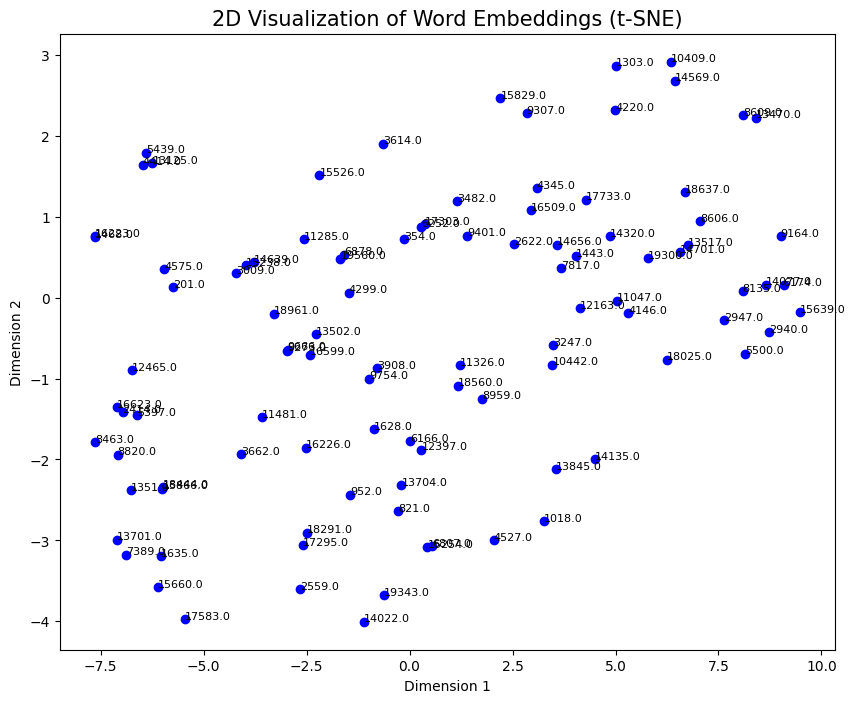


Word: rouge
Occurrences: 100
Polysemy score: 0.1349
Review ID 14656.0: [-0.08459795 -0.3502927  -0.11068828 -0.03387534  0.08603291]...
Review ID 1635.0: [-0.02127355 -0.21864969  0.05332581  0.10295939  0.01373989]...
Review ID 1018.0: [-0.18690115 -0.24919426 -0.21622321  0.05489434  0.12010573]...
Review ID 15639.0: [-0.07540462  0.03832376 -0.0112169   0.07120901 -0.11290507]...
Review ID 13125.0: [-0.07799672 -0.2527855  -0.06033889  0.06297231 -0.07282878]...
Review ID 13701.0: [-0.01750248 -0.333352    0.01976858  0.13749115  0.10600901]...
Review ID 4575.0: [-0.16723165 -0.39040694 -0.02225801  0.19022153  0.10249476]...
Review ID 8820.0: [-0.04262028 -0.27236962  0.15496016  0.07523391 -0.02149181]...
Review ID 17303.0: [-0.01939363 -0.3428556   0.02922579  0.00584601  0.10776805]...
Review ID 2414.0: [ 0.00236015 -0.36832333 -0.03163987  0.13160357  0.03345467]...
Review ID 14701.0: [-0.03878871  0.01570579  0.01465387  0.05498168 -0.03616593]...
Review ID 15238.0: [ 0.03406

In [6]:
target_words = ['rouge']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)

15526 3614相对位置有变化


Analyzing word: rouge


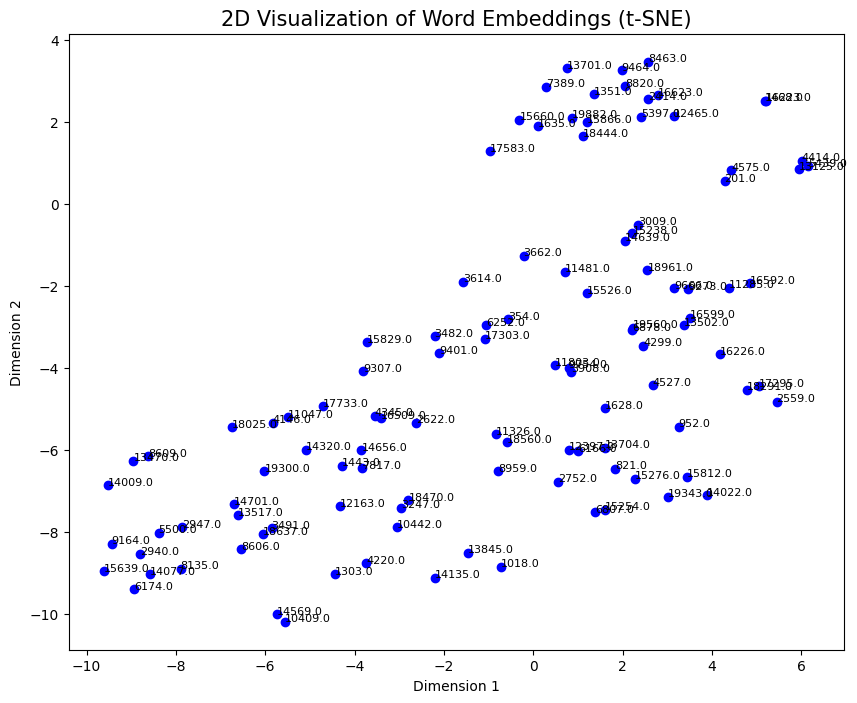


Word: rouge
Occurrences: 110
Polysemy score: 0.1343
Review ID 14656.0: [-0.08459795 -0.3502927  -0.11068828 -0.03387534  0.08603291]...
Review ID 1635.0: [-0.02127355 -0.21864969  0.05332581  0.10295939  0.01373989]...
Review ID 1018.0: [-0.18690115 -0.24919426 -0.21622321  0.05489434  0.12010573]...
Review ID 15639.0: [-0.07540462  0.03832376 -0.0112169   0.07120901 -0.11290507]...
Review ID 13125.0: [-0.07799672 -0.2527855  -0.06033889  0.06297231 -0.07282878]...
Review ID 13701.0: [-0.01750248 -0.333352    0.01976858  0.13749115  0.10600901]...
Review ID 4575.0: [-0.16723165 -0.39040694 -0.02225801  0.19022153  0.10249476]...
Review ID 8820.0: [-0.04262028 -0.27236962  0.15496016  0.07523391 -0.02149181]...
Review ID 17303.0: [-0.01939363 -0.3428556   0.02922579  0.00584601  0.10776805]...
Review ID 2414.0: [ 0.00236015 -0.36832333 -0.03163987  0.13160357  0.03345467]...
Review ID 14701.0: [-0.03878871  0.01570579  0.01465387  0.05498168 -0.03616593]...
Review ID 15238.0: [ 0.03406

In [7]:
target_words = ['rouge']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)


Analyzing word: carte


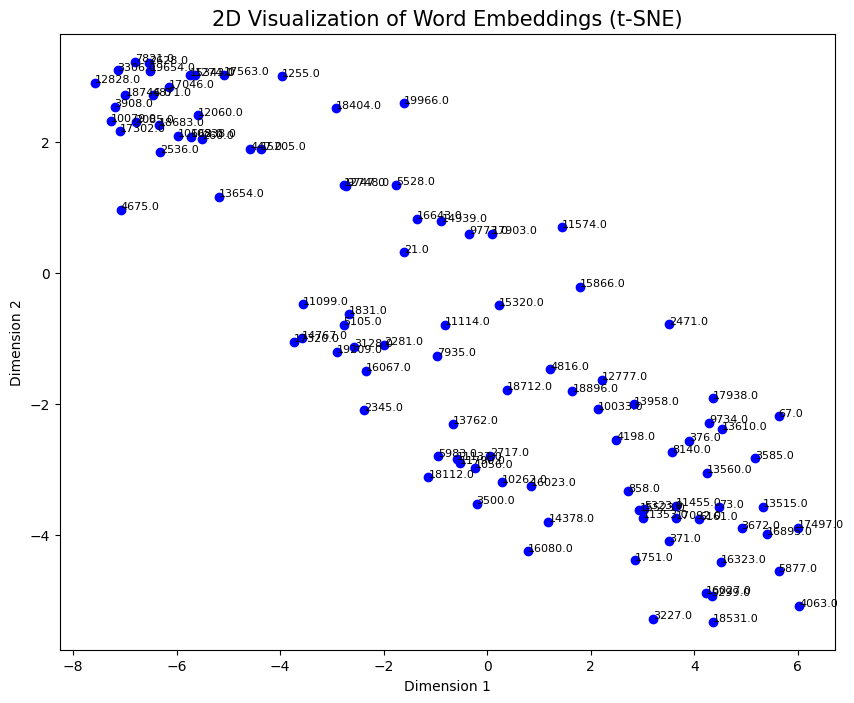


Word: carte
Occurrences: 100
Polysemy score: 0.1638
Review ID 18746.0: [-0.03377141  0.12111717  0.00466347  0.1834575  -0.02014529]...
Review ID 1274.0: [-0.09512544  0.04999993  0.0066408   0.13744202  0.01495318]...
Review ID 371.0: [-0.05287344  0.2702997  -0.08734989  0.00318497  0.04080261]...
Review ID 16067.0: [-0.02103006  0.10484169 -0.02529492 -0.11553866  0.02975475]...
Review ID 18531.0: [-0.02731205  0.3997633  -0.1958402   0.00502031  0.04168026]...
Review ID 13560.0: [ 0.14666404  0.21836664 -0.03262433  0.01700905 -0.01392355]...
Review ID 4675.0: [ 0.04139964  0.22080362 -0.1145056   0.06988306 -0.04752056]...
Review ID 5105.0: [-0.01825004  0.20144969 -0.17033564 -0.07675477  0.05475085]...
Review ID 17903.0: [-0.06308758 -0.04239094 -0.08604573 -0.05472056  0.13227886]...
Review ID 1751.0: [-0.0618601   0.33598918 -0.05488419  0.04038211  0.06862049]...
Review ID 10079.0: [ 0.00566061  0.09188987 -0.02428986  0.19286166 -0.08358805]...
Review ID 9299.0: [-0.0204083

In [8]:
target_words = ['carte']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)



Analyzing word: carte


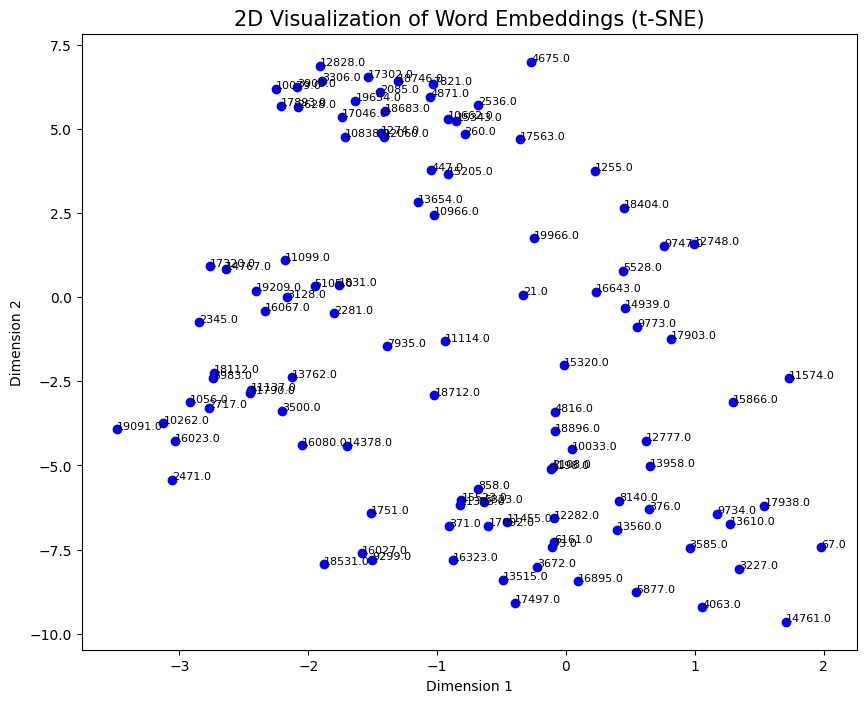


Word: carte
Occurrences: 106
Polysemy score: 0.1653
Review ID 18746.0: [-0.03377141  0.12111717  0.00466347  0.1834575  -0.02014529]...
Review ID 1274.0: [-0.09512544  0.04999993  0.0066408   0.13744202  0.01495318]...
Review ID 371.0: [-0.05287344  0.2702997  -0.08734989  0.00318497  0.04080261]...
Review ID 16067.0: [-0.02103006  0.10484169 -0.02529492 -0.11553866  0.02975475]...
Review ID 18531.0: [-0.02731205  0.3997633  -0.1958402   0.00502031  0.04168026]...
Review ID 13560.0: [ 0.14666404  0.21836664 -0.03262433  0.01700905 -0.01392355]...
Review ID 4675.0: [ 0.04139964  0.22080362 -0.1145056   0.06988306 -0.04752056]...
Review ID 5105.0: [-0.01825004  0.20144969 -0.17033564 -0.07675477  0.05475085]...
Review ID 17903.0: [-0.06308758 -0.04239094 -0.08604573 -0.05472056  0.13227886]...
Review ID 1751.0: [-0.0618601   0.33598918 -0.05488419  0.04038211  0.06862049]...
Review ID 10079.0: [ 0.00566061  0.09188987 -0.02428986  0.19286166 -0.08358805]...
Review ID 9299.0: [-0.0204083

In [9]:
target_words = ['carte']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)



Analyzing word: règle


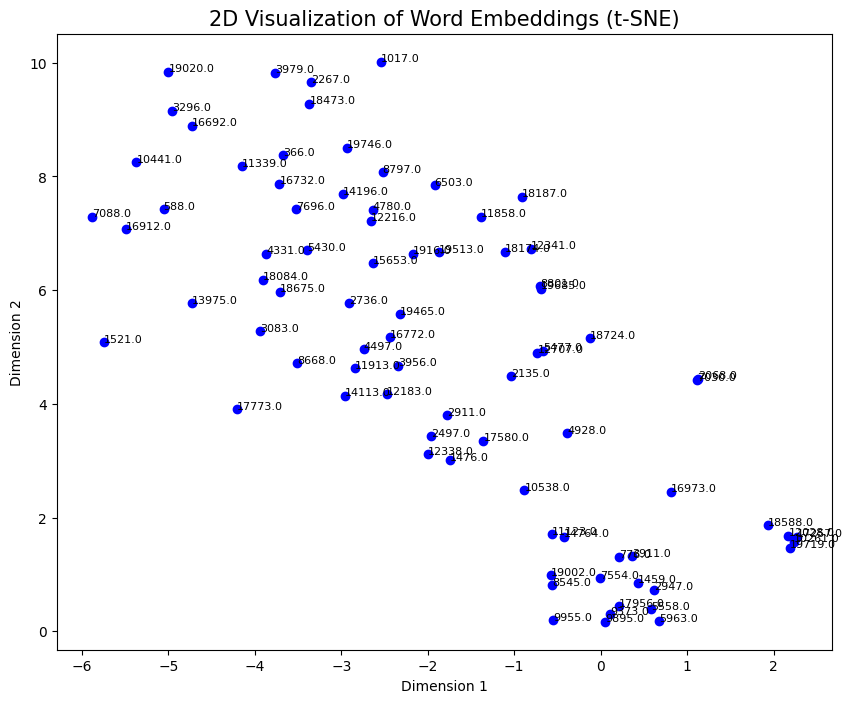


Word: règle
Occurrences: 81
Polysemy score: 0.1519
Review ID 7030.0: [ 0.07559747  0.05971362  0.02755318  0.179573   -0.12739643]...
Review ID 366.0: [-0.1313591   0.05785267 -0.01652384  0.09337315 -0.09130712]...
Review ID 4497.0: [-0.08138379 -0.15245111  0.07353037  0.19156401  0.0430762 ]...
Review ID 7088.0: [-0.05649048 -0.05968855 -0.09106534  0.07987882 -0.06990158]...
Review ID 3911.0: [ 0.08641718 -0.02123497  0.02526887  0.30825692  0.1721022 ]...
Review ID 5963.0: [0.09069269 0.19878156 0.05158291 0.33718833 0.17575143]...
Review ID 2267.0: [-0.01821731  0.11947744 -0.21661535 -0.05843761 -0.15463361]...
Review ID 12341.0: [ 0.07638377  0.1949561  -0.14379245  0.17647664  0.04827679]...
Review ID 1459.0: [0.04672245 0.19576985 0.00927743 0.32661256 0.19138512]...
Review ID 2736.0: [-0.03171381  0.18029508  0.04628484  0.12035861  0.10579222]...
Review ID 12028.0: [ 0.09790154 -0.07922636  0.30709338  0.1374889  -0.04952805]...
Review ID 7696.0: [-0.11967734 -0.17737302  

In [10]:
target_words = ['règle']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)


Analyzing word: règle


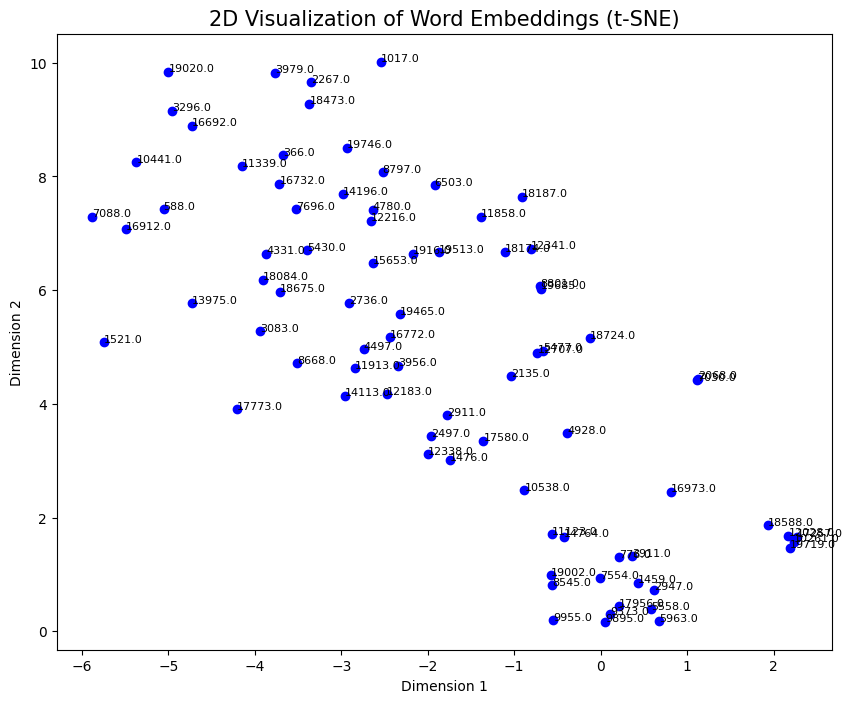


Word: règle
Occurrences: 81
Polysemy score: 0.1519
Review ID 7030.0: [ 0.07559747  0.05971362  0.02755318  0.179573   -0.12739643]...
Review ID 366.0: [-0.1313591   0.05785267 -0.01652384  0.09337315 -0.09130712]...
Review ID 4497.0: [-0.08138379 -0.15245111  0.07353037  0.19156401  0.0430762 ]...
Review ID 7088.0: [-0.05649048 -0.05968855 -0.09106534  0.07987882 -0.06990158]...
Review ID 3911.0: [ 0.08641718 -0.02123497  0.02526887  0.30825692  0.1721022 ]...
Review ID 5963.0: [0.09069269 0.19878156 0.05158291 0.33718833 0.17575143]...
Review ID 2267.0: [-0.01821731  0.11947744 -0.21661535 -0.05843761 -0.15463361]...
Review ID 12341.0: [ 0.07638377  0.1949561  -0.14379245  0.17647664  0.04827679]...
Review ID 1459.0: [0.04672245 0.19576985 0.00927743 0.32661256 0.19138512]...
Review ID 2736.0: [-0.03171381  0.18029508  0.04628484  0.12035861  0.10579222]...
Review ID 12028.0: [ 0.09790154 -0.07922636  0.30709338  0.1374889  -0.04952805]...
Review ID 7696.0: [-0.11967734 -0.17737302  

In [11]:
target_words = ['règle']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)


Analyzing word: film


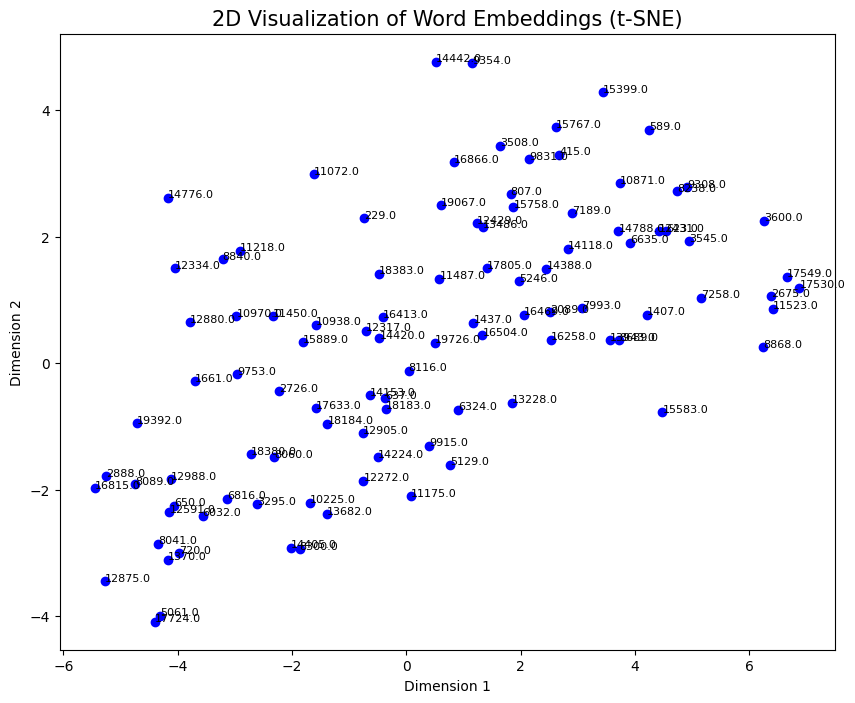


Word: film
Occurrences: 100
Polysemy score: 0.0536
Review ID 13943.0: [-0.0336085  -0.00780981 -0.04528157  0.05811678 -0.08476418]...
Review ID 14442.0: [-0.03285702 -0.07877821 -0.01723691  0.00465568 -0.02160107]...
Review ID 12880.0: [-0.0242883  -0.03927249 -0.13289043 -0.01897267 -0.05596074]...
Review ID 17724.0: [ 0.07893607  0.00392999 -0.17824961 -0.01874455 -0.04857278]...
Review ID 15583.0: [-0.06902392 -0.05331904 -0.06880073  0.08504577 -0.11112201]...
Review ID 9354.0: [-0.00525682 -0.03920087 -0.05231322  0.05171037 -0.06661966]...
Review ID 8089.0: [ 0.06793609 -0.06430577  0.14780745  0.13751414 -0.11221456]...
Review ID 637.0: [-0.03044715 -0.03027809  0.05677479  0.13285962 -0.07169037]...
Review ID 12988.0: [ 0.03160152  0.04342157 -0.03186363  0.12218463 -0.05766339]...
Review ID 14420.0: [-0.02089636 -0.05468005  0.00394456  0.09461433 -0.06146811]...
Review ID 14405.0: [-0.07235518  0.03908554 -0.08795571  0.07236492 -0.01760493]...
Review ID 10938.0: [ 0.02686

In [12]:
target_words = ['film']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)


Analyzing word: film


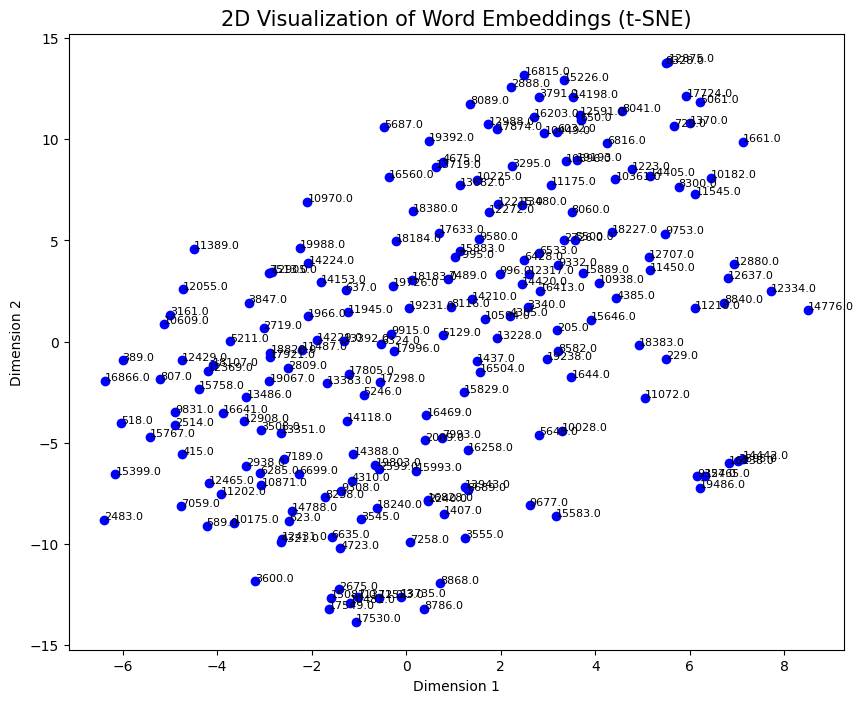


Word: film
Occurrences: 200
Polysemy score: 0.0469
Review ID 13943.0: [-0.0336085  -0.00780981 -0.04528157  0.05811678 -0.08476418]...
Review ID 14442.0: [-0.03285702 -0.07877821 -0.01723691  0.00465568 -0.02160107]...
Review ID 12880.0: [-0.0242883  -0.03927249 -0.13289043 -0.01897267 -0.05596074]...
Review ID 17724.0: [ 0.07893607  0.00392999 -0.17824961 -0.01874455 -0.04857278]...
Review ID 15583.0: [-0.06902392 -0.05331904 -0.06880073  0.08504577 -0.11112201]...
Review ID 9354.0: [-0.00525682 -0.03920087 -0.05231322  0.05171037 -0.06661966]...
Review ID 8089.0: [ 0.06793609 -0.06430577  0.14780745  0.13751414 -0.11221456]...
Review ID 637.0: [-0.03044715 -0.03027809  0.05677479  0.13285962 -0.07169037]...
Review ID 12988.0: [ 0.03160152  0.04342157 -0.03186363  0.12218463 -0.05766339]...
Review ID 14420.0: [-0.02089636 -0.05468005  0.00394456  0.09461433 -0.06146811]...
Review ID 14405.0: [-0.07235518  0.03908554 -0.08795571  0.07236492 -0.01760493]...
Review ID 10938.0: [ 0.02686

In [13]:
target_words = ['film']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)


Analyzing word: film


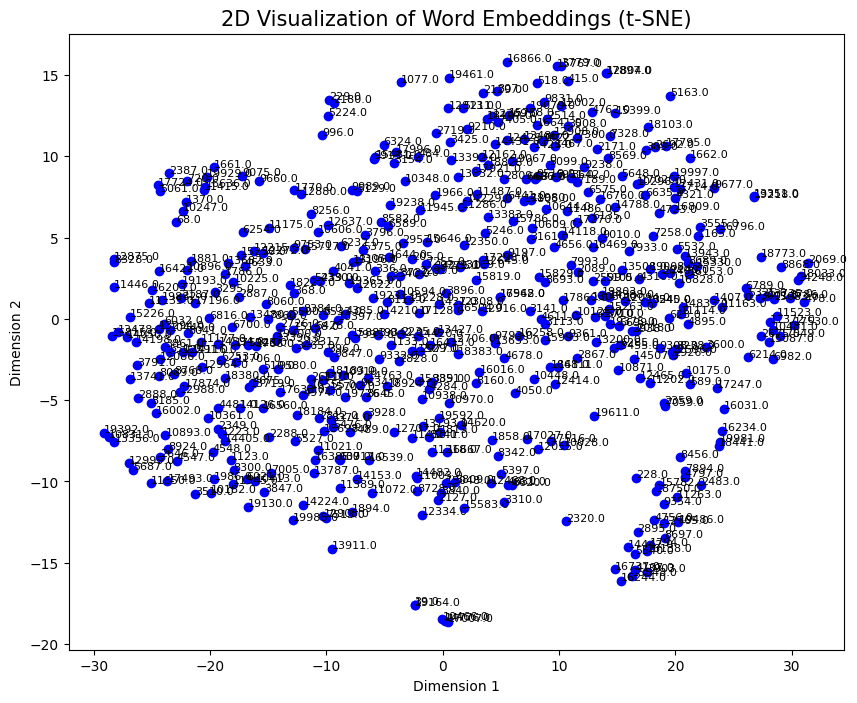


Word: film
Occurrences: 500
Polysemy score: 0.0520
Review ID 13943.0: [-0.0336085  -0.00780981 -0.04528157  0.05811678 -0.08476418]...
Review ID 14442.0: [-0.03285702 -0.07877821 -0.01723691  0.00465568 -0.02160107]...
Review ID 12880.0: [-0.0242883  -0.03927249 -0.13289043 -0.01897267 -0.05596074]...
Review ID 17724.0: [ 0.07893607  0.00392999 -0.17824961 -0.01874455 -0.04857278]...
Review ID 15583.0: [-0.06902392 -0.05331904 -0.06880073  0.08504577 -0.11112201]...
Review ID 9354.0: [-0.00525682 -0.03920087 -0.05231322  0.05171037 -0.06661966]...
Review ID 8089.0: [ 0.06793609 -0.06430577  0.14780745  0.13751414 -0.11221456]...
Review ID 637.0: [-0.03044715 -0.03027809  0.05677479  0.13285962 -0.07169037]...
Review ID 12988.0: [ 0.03160152  0.04342157 -0.03186363  0.12218463 -0.05766339]...
Review ID 14420.0: [-0.02089636 -0.05468005  0.00394456  0.09461433 -0.06146811]...
Review ID 14405.0: [-0.07235518  0.03908554 -0.08795571  0.07236492 -0.01760493]...
Review ID 10938.0: [ 0.02686

In [14]:
target_words = ['film']
results = quick_polysemy_analysis(file_path, target_words, sample_size=500)


Analyzing word: film


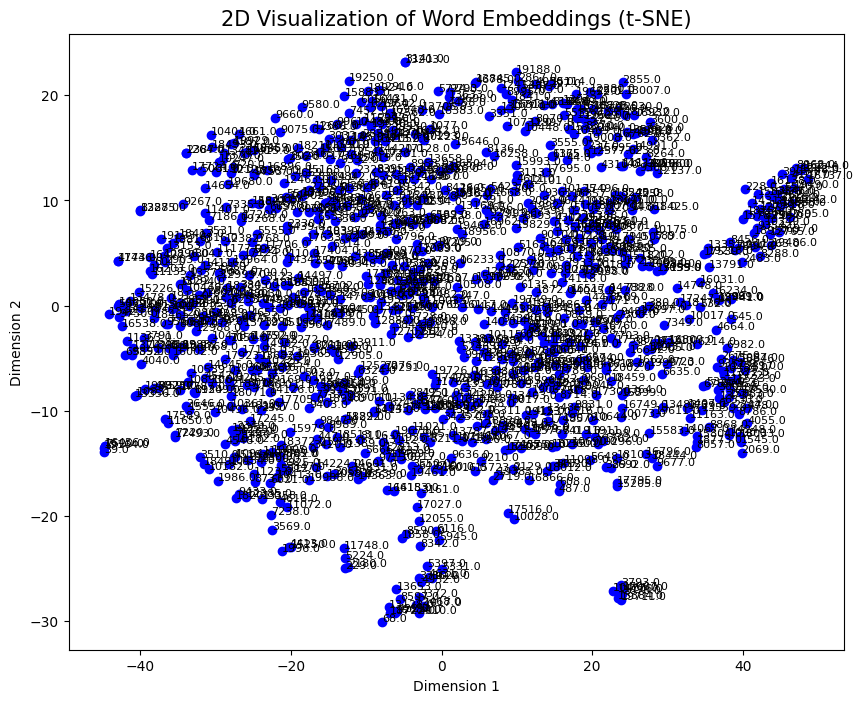


Word: film
Occurrences: 1000
Polysemy score: 0.0584
Review ID 13943.0: [-0.0336085  -0.00780981 -0.04528157  0.05811678 -0.08476418]...
Review ID 14442.0: [-0.03285702 -0.07877821 -0.01723691  0.00465568 -0.02160107]...
Review ID 12880.0: [-0.0242883  -0.03927249 -0.13289043 -0.01897267 -0.05596074]...
Review ID 17724.0: [ 0.07893607  0.00392999 -0.17824961 -0.01874455 -0.04857278]...
Review ID 15583.0: [-0.06902392 -0.05331904 -0.06880073  0.08504577 -0.11112201]...
Review ID 9354.0: [-0.00525682 -0.03920087 -0.05231322  0.05171037 -0.06661966]...
Review ID 8089.0: [ 0.06793609 -0.06430577  0.14780745  0.13751414 -0.11221456]...
Review ID 637.0: [-0.03044715 -0.03027809  0.05677479  0.13285962 -0.07169037]...
Review ID 12988.0: [ 0.03160152  0.04342157 -0.03186363  0.12218463 -0.05766339]...
Review ID 14420.0: [-0.02089636 -0.05468005  0.00394456  0.09461433 -0.06146811]...
Review ID 14405.0: [-0.07235518  0.03908554 -0.08795571  0.07236492 -0.01760493]...
Review ID 10938.0: [ 0.0268

In [15]:
target_words = ['film']
results = quick_polysemy_analysis(file_path, target_words, sample_size=1000)


Analyzing word: histoire


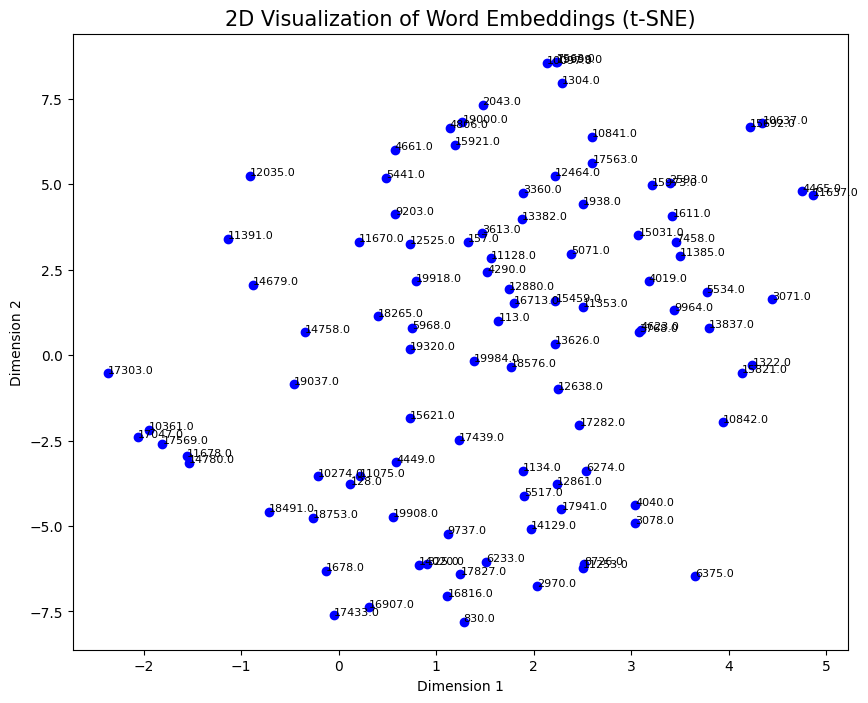


Word: histoire
Occurrences: 100
Polysemy score: 0.1090
Review ID 18753.0: [-0.00950986 -0.19498628  0.13899355  0.02429938 -0.12632746]...
Review ID 1938.0: [ 0.05326986  0.19551179  0.08023502  0.12502548 -0.10259068]...
Review ID 157.0: [ 0.07962727 -0.03809617  0.01287515  0.16828617 -0.0737323 ]...
Review ID 15459.0: [ 0.08218613  0.2400684   0.03087641  0.00305375 -0.09779622]...
Review ID 15031.0: [ 0.00800247  0.12871842 -0.04737178  0.06112363 -0.11164878]...
Review ID 18576.0: [ 0.06443074  0.10360884  0.03315109  0.00322903 -0.09731546]...
Review ID 17282.0: [-0.01854775  0.23152152  0.01772322 -0.01809511 -0.1454678 ]...
Review ID 17827.0: [-0.01907969  0.09586279  0.24356186 -0.04516999 -0.10293824]...
Review ID 13626.0: [ 0.0885423   0.09234277  0.03761729  0.0446177  -0.15743323]...
Review ID 12861.0: [ 0.00228591 -0.01079263  0.00302193 -0.03268277 -0.19462265]...
Review ID 12638.0: [ 0.04032521 -0.07022563  0.0073754  -0.07132894 -0.10436905]...
Review ID 4806.0: [ 0.0

In [16]:
target_words = ['histoire']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)


Analyzing word: histoire


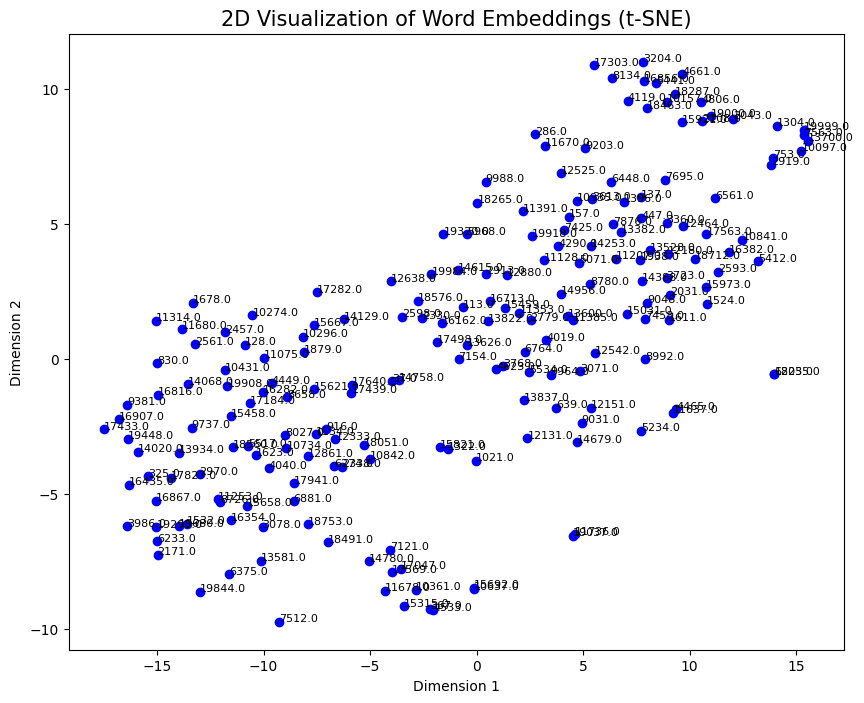


Word: histoire
Occurrences: 200
Polysemy score: 0.0975
Review ID 18753.0: [-0.00950986 -0.19498628  0.13899355  0.02429938 -0.12632746]...
Review ID 1938.0: [ 0.05326986  0.19551179  0.08023502  0.12502548 -0.10259068]...
Review ID 157.0: [ 0.07962727 -0.03809617  0.01287515  0.16828617 -0.0737323 ]...
Review ID 15459.0: [ 0.08218613  0.2400684   0.03087641  0.00305375 -0.09779622]...
Review ID 15031.0: [ 0.00800247  0.12871842 -0.04737178  0.06112363 -0.11164878]...
Review ID 18576.0: [ 0.06443074  0.10360884  0.03315109  0.00322903 -0.09731546]...
Review ID 17282.0: [-0.01854775  0.23152152  0.01772322 -0.01809511 -0.1454678 ]...
Review ID 17827.0: [-0.01907969  0.09586279  0.24356186 -0.04516999 -0.10293824]...
Review ID 13626.0: [ 0.0885423   0.09234277  0.03761729  0.0446177  -0.15743323]...
Review ID 12861.0: [ 0.00228591 -0.01079263  0.00302193 -0.03268277 -0.19462265]...
Review ID 12638.0: [ 0.04032521 -0.07022563  0.0073754  -0.07132894 -0.10436905]...
Review ID 4806.0: [ 0.0

In [17]:
target_words = ['histoire']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)


Analyzing word: histoire


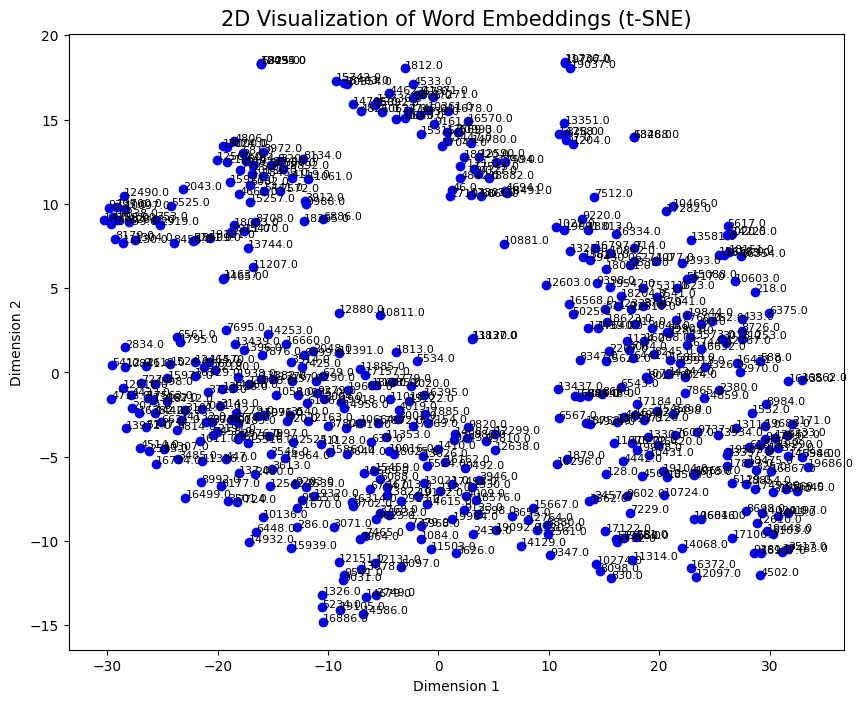


Word: histoire
Occurrences: 500
Polysemy score: 0.0954
Review ID 18753.0: [-0.00950986 -0.19498628  0.13899355  0.02429938 -0.12632746]...
Review ID 1938.0: [ 0.05326986  0.19551179  0.08023502  0.12502548 -0.10259068]...
Review ID 157.0: [ 0.07962727 -0.03809617  0.01287515  0.16828617 -0.0737323 ]...
Review ID 15459.0: [ 0.08218613  0.2400684   0.03087641  0.00305375 -0.09779622]...
Review ID 15031.0: [ 0.00800247  0.12871842 -0.04737178  0.06112363 -0.11164878]...
Review ID 18576.0: [ 0.06443074  0.10360884  0.03315109  0.00322903 -0.09731546]...
Review ID 17282.0: [-0.01854775  0.23152152  0.01772322 -0.01809511 -0.1454678 ]...
Review ID 17827.0: [-0.01907969  0.09586279  0.24356186 -0.04516999 -0.10293824]...
Review ID 13626.0: [ 0.0885423   0.09234277  0.03761729  0.0446177  -0.15743323]...
Review ID 12861.0: [ 0.00228591 -0.01079263  0.00302193 -0.03268277 -0.19462265]...
Review ID 12638.0: [ 0.04032521 -0.07022563  0.0073754  -0.07132894 -0.10436905]...
Review ID 4806.0: [ 0.0

In [18]:
target_words = ['histoire']
results = quick_polysemy_analysis(file_path, target_words, sample_size=500)


Analyzing word: histoire


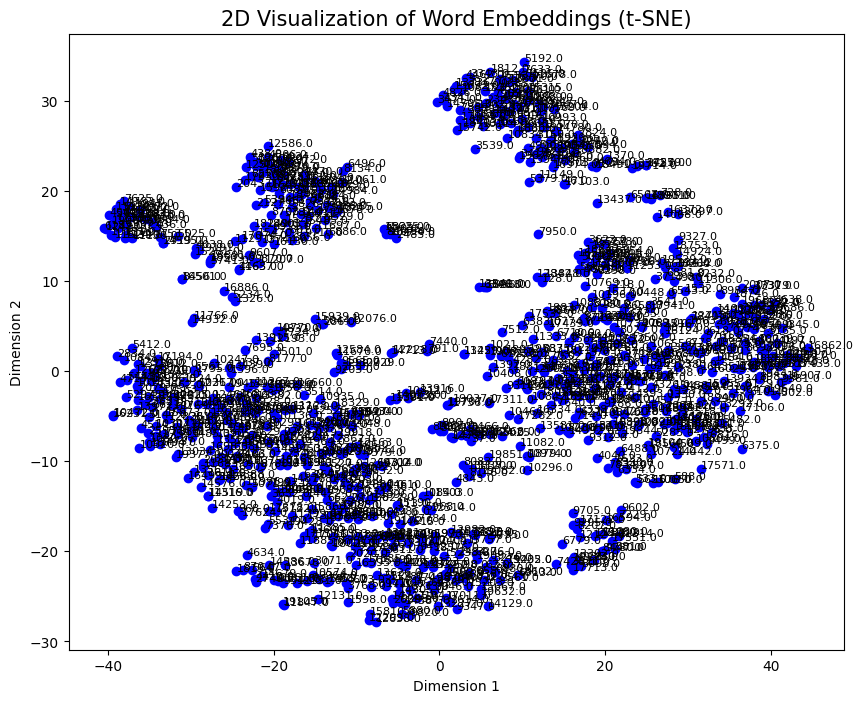


Word: histoire
Occurrences: 1000
Polysemy score: 0.0965
Review ID 18753.0: [-0.00950986 -0.19498628  0.13899355  0.02429938 -0.12632746]...
Review ID 1938.0: [ 0.05326986  0.19551179  0.08023502  0.12502548 -0.10259068]...
Review ID 157.0: [ 0.07962727 -0.03809617  0.01287515  0.16828617 -0.0737323 ]...
Review ID 15459.0: [ 0.08218613  0.2400684   0.03087641  0.00305375 -0.09779622]...
Review ID 15031.0: [ 0.00800247  0.12871842 -0.04737178  0.06112363 -0.11164878]...
Review ID 18576.0: [ 0.06443074  0.10360884  0.03315109  0.00322903 -0.09731546]...
Review ID 17282.0: [-0.01854775  0.23152152  0.01772322 -0.01809511 -0.1454678 ]...
Review ID 17827.0: [-0.01907969  0.09586279  0.24356186 -0.04516999 -0.10293824]...
Review ID 13626.0: [ 0.0885423   0.09234277  0.03761729  0.0446177  -0.15743323]...
Review ID 12861.0: [ 0.00228591 -0.01079263  0.00302193 -0.03268277 -0.19462265]...
Review ID 12638.0: [ 0.04032521 -0.07022563  0.0073754  -0.07132894 -0.10436905]...
Review ID 4806.0: [ 0.

In [19]:
target_words = ['histoire']
results = quick_polysemy_analysis(file_path, target_words, sample_size=1000)


Analyzing word: tour


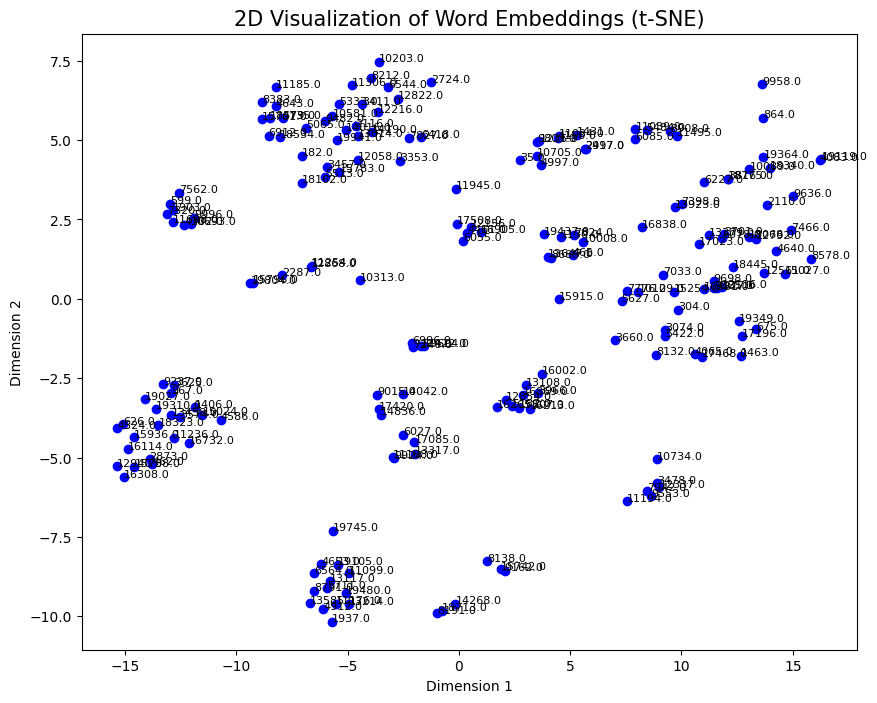


Word: tour
Occurrences: 195
Polysemy score: 0.1518
Review ID 13379.0: [-0.00357594  0.1673318   0.07507176  0.08401991 -0.07432462]...
Review ID 1937.0: [0.11655645 0.00316541 0.04449401 0.18527986 0.03295182]...
Review ID 15796.0: [-0.13271563 -0.20917535  0.09083174  0.20594968  0.08402162]...
Review ID 9958.0: [ 0.02122733  0.03161027 -0.04056808  0.2174626   0.01541233]...
Review ID 7240.0: [-0.01437274  0.04905124 -0.04242359  0.09425826  0.1205221 ]...
Review ID 15742.0: [-0.0491787   0.00448035 -0.17723367 -0.04304194  0.00092395]...
Review ID 5627.0: [-0.00304334  0.2584884  -0.08208004  0.04425107  0.02108374]...
Review ID 1903.0: [-0.10605662 -0.05505075 -0.17693223 -0.02360689  0.07801391]...
Review ID 11188.0: [-0.03415236 -0.07161857  0.23455381  0.14811033  0.06590875]...
Review ID 11185.0: [ 0.09227693  0.04713527 -0.10700665  0.07518344  0.0166681 ]...
Review ID 19105.0: [ 0.11681554 -0.09541713  0.15456592  0.13766713  0.02909844]...
Review ID 2116.0: [-0.00932731  0.

In [21]:
target_words = ['tour']
results = quick_polysemy_analysis(file_path, target_words, sample_size=500)


Analyzing word: tour


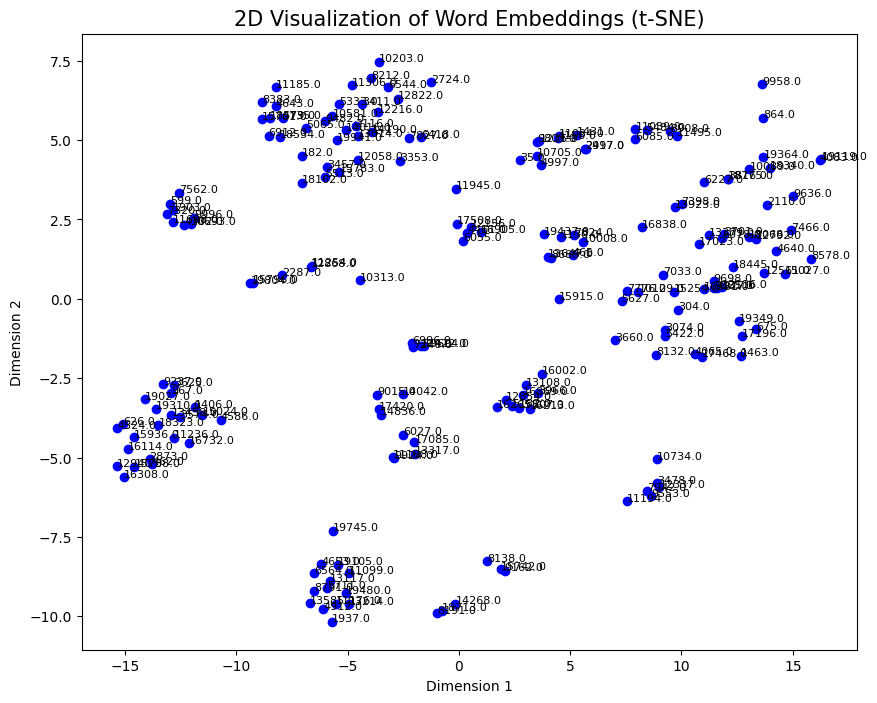


Word: tour
Occurrences: 195
Polysemy score: 0.1518
Review ID 13379.0: [-0.00357594  0.1673318   0.07507176  0.08401991 -0.07432462]...
Review ID 1937.0: [0.11655645 0.00316541 0.04449401 0.18527986 0.03295182]...
Review ID 15796.0: [-0.13271563 -0.20917535  0.09083174  0.20594968  0.08402162]...
Review ID 9958.0: [ 0.02122733  0.03161027 -0.04056808  0.2174626   0.01541233]...
Review ID 7240.0: [-0.01437274  0.04905124 -0.04242359  0.09425826  0.1205221 ]...
Review ID 15742.0: [-0.0491787   0.00448035 -0.17723367 -0.04304194  0.00092395]...
Review ID 5627.0: [-0.00304334  0.2584884  -0.08208004  0.04425107  0.02108374]...
Review ID 1903.0: [-0.10605662 -0.05505075 -0.17693223 -0.02360689  0.07801391]...
Review ID 11188.0: [-0.03415236 -0.07161857  0.23455381  0.14811033  0.06590875]...
Review ID 11185.0: [ 0.09227693  0.04713527 -0.10700665  0.07518344  0.0166681 ]...
Review ID 19105.0: [ 0.11681554 -0.09541713  0.15456592  0.13766713  0.02909844]...
Review ID 2116.0: [-0.00932731  0.

In [22]:
target_words = ['tour']
results = quick_polysemy_analysis(file_path, target_words, sample_size=1000)


Analyzing word: cœur


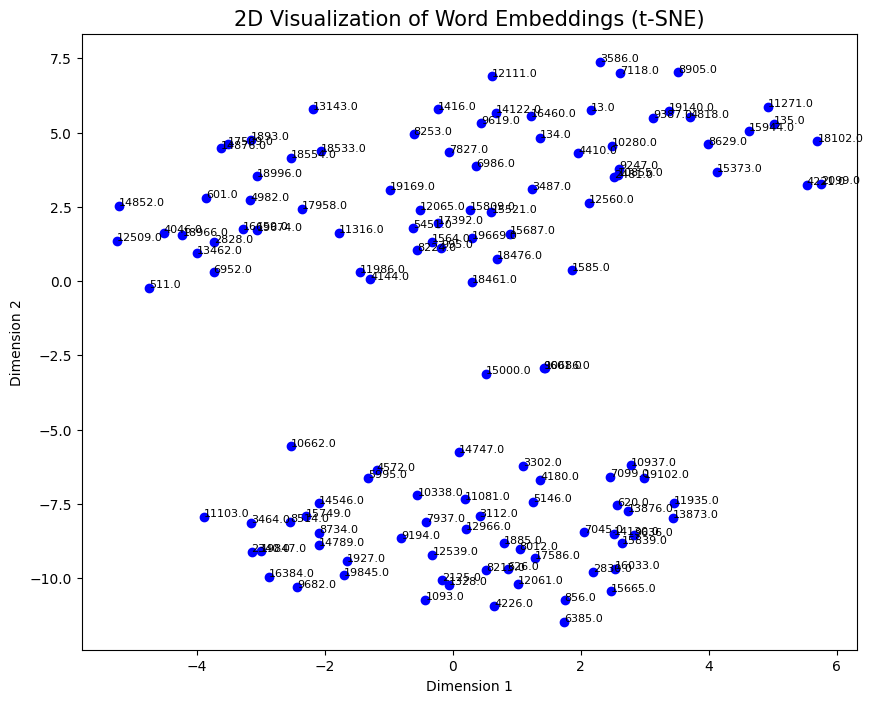


Word: cœur
Occurrences: 124
Polysemy score: 0.1273
Review ID 2125.0: [ 0.19887112  0.05513408 -0.08741158  0.1012312  -0.01904023]...
Review ID 6986.0: [ 0.08807915  0.02018487 -0.15193269  0.15676804 -0.10537289]...
Review ID 4982.0: [ 0.18710035  0.14893255 -0.24797785  0.02311227 -0.05576219]...
Review ID 12065.0: [ 0.15357019 -0.09988959 -0.16901591  0.05985219 -0.07051171]...
Review ID 8629.0: [ 0.05937125 -0.05301052 -0.2544658   0.17149715 -0.06494523]...
Review ID 14789.0: [ 0.1517291  -0.12153603 -0.09631991  0.23283824 -0.02377399]...
Review ID 9194.0: [ 0.18413377 -0.01943808 -0.05212347  0.167292    0.00245604]...
Review ID 19845.0: [ 0.13769071  0.04806459  0.00622741  0.21999818 -0.02270904]...
Review ID 19674.0: [ 0.16771875 -0.11687388 -0.2940442   0.03783661 -0.01845209]...
Review ID 601.0: [ 0.07289074  0.01961704 -0.12407661  0.04029984 -0.12706234]...
Review ID 3586.0: [ 0.0919803   0.2892725  -0.36624214  0.07613061  0.05914434]...
Review ID 15944.0: [-0.0198689  

In [23]:
target_words = ['cœur']
results = quick_polysemy_analysis(file_path, target_words, sample_size=500)


Analyzing word: cœur


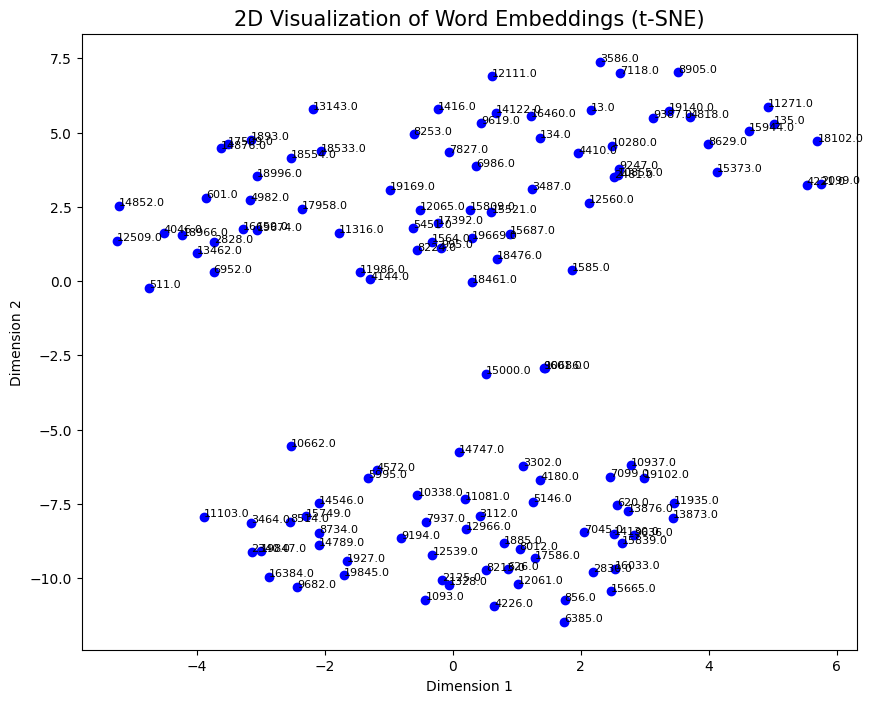


Word: cœur
Occurrences: 124
Polysemy score: 0.1273
Review ID 2125.0: [ 0.19887112  0.05513408 -0.08741158  0.1012312  -0.01904023]...
Review ID 6986.0: [ 0.08807915  0.02018487 -0.15193269  0.15676804 -0.10537289]...
Review ID 4982.0: [ 0.18710035  0.14893255 -0.24797785  0.02311227 -0.05576219]...
Review ID 12065.0: [ 0.15357019 -0.09988959 -0.16901591  0.05985219 -0.07051171]...
Review ID 8629.0: [ 0.05937125 -0.05301052 -0.2544658   0.17149715 -0.06494523]...
Review ID 14789.0: [ 0.1517291  -0.12153603 -0.09631991  0.23283824 -0.02377399]...
Review ID 9194.0: [ 0.18413377 -0.01943808 -0.05212347  0.167292    0.00245604]...
Review ID 19845.0: [ 0.13769071  0.04806459  0.00622741  0.21999818 -0.02270904]...
Review ID 19674.0: [ 0.16771875 -0.11687388 -0.2940442   0.03783661 -0.01845209]...
Review ID 601.0: [ 0.07289074  0.01961704 -0.12407661  0.04029984 -0.12706234]...
Review ID 3586.0: [ 0.0919803   0.2892725  -0.36624214  0.07613061  0.05914434]...
Review ID 15944.0: [-0.0198689  

In [24]:
target_words = ['cœur']
results = quick_polysemy_analysis(file_path, target_words, sample_size=1000)


Analyzing word: hauteur


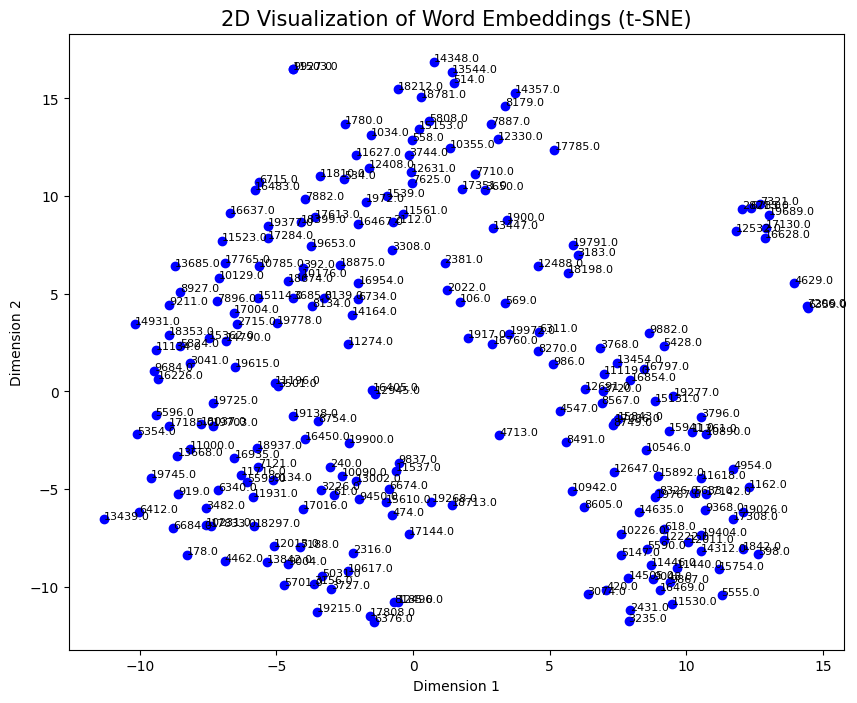


Word: hauteur
Occurrences: 228
Polysemy score: 0.1200
Review ID 19377.0: [ 0.03597611  0.00843945 -0.385304   -0.08009402 -0.18669079]...
Review ID 6376.0: [ 0.10927515 -0.00570228 -0.31283534 -0.07503812 -0.13616522]...
Review ID 558.0: [ 0.029688   -0.15077889 -0.34331158 -0.1426632  -0.17528458]...
Review ID 18198.0: [ 0.07303193  0.1842351  -0.3000268  -0.02397263 -0.07724247]...
Review ID 1034.0: [-0.07269634 -0.1455252  -0.3784905  -0.12639469 -0.14802128]...
Review ID 17808.0: [ 0.10991048 -0.04661405 -0.37142518 -0.06576195 -0.14406717]...
Review ID 2316.0: [ 0.06416219  0.13284713 -0.24696504 -0.01620072 -0.15492049]...
Review ID 17351.0: [-0.08003549  0.10210987 -0.28826204 -0.07568809 -0.12508325]...
Review ID 14164.0: [ 0.11330459 -0.04708654 -0.27710295 -0.07061069 -0.14084958]...
Review ID 11530.0: [ 0.12201709  0.06458674 -0.42769843  0.03314966 -0.10162912]...
Review ID 19215.0: [ 0.08313008  0.01574257 -0.36616555 -0.04454982 -0.13562416]...
Review ID 1842.0: [ 0.1113

In [25]:
target_words = ['hauteur']
results = quick_polysemy_analysis(file_path, target_words, sample_size=500)


Analyzing word: français


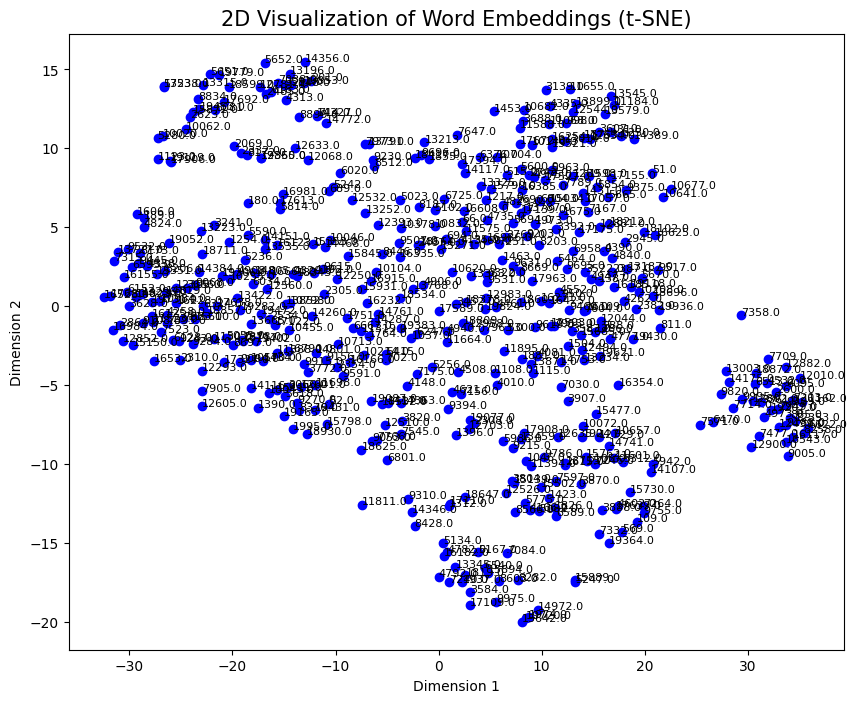


Word: français
Occurrences: 500
Polysemy score: 0.1043
Review ID 2623.0: [ 0.05529703 -0.05455001  0.05167905 -0.1324541   0.07944793]...
Review ID 19052.0: [ 0.01201788 -0.04843901 -0.21177216 -0.0493848   0.06108226]...
Review ID 4973.0: [-0.01991007 -0.0117149  -0.03103085 -0.04273343  0.07252071]...
Review ID 9284.0: [ 0.06435125 -0.03742328 -0.25510406 -0.0478766   0.06573822]...
Review ID 6247.0: [ 0.04916367  0.07133684 -0.18461625 -0.00186633  0.08441206]...
Review ID 13852.0: [ 0.0830385  -0.0773619  -0.25976795 -0.0765502   0.03389331]...
Review ID 2148.0: [ 0.0655611   0.06548276 -0.19187368 -0.15553994  0.02620807]...
Review ID 1108.0: [ 0.02173703  0.12449552 -0.29960626 -0.03006172  0.04153169]...
Review ID 7604.0: [ 0.07538503  0.10425516 -0.20512074 -0.05324388  0.13026783]...
Review ID 7156.0: [ 0.05470401 -0.02968173 -0.24086891 -0.05905349  0.03975599]...
Review ID 6034.0: [ 0.03126904 -0.14079177 -0.17740677 -0.06906412  0.11638282]...
Review ID 19779.0: [ 0.066467

In [26]:
target_words = ['français']
results = quick_polysemy_analysis(file_path, target_words, sample_size=500)


Analyzing word: français


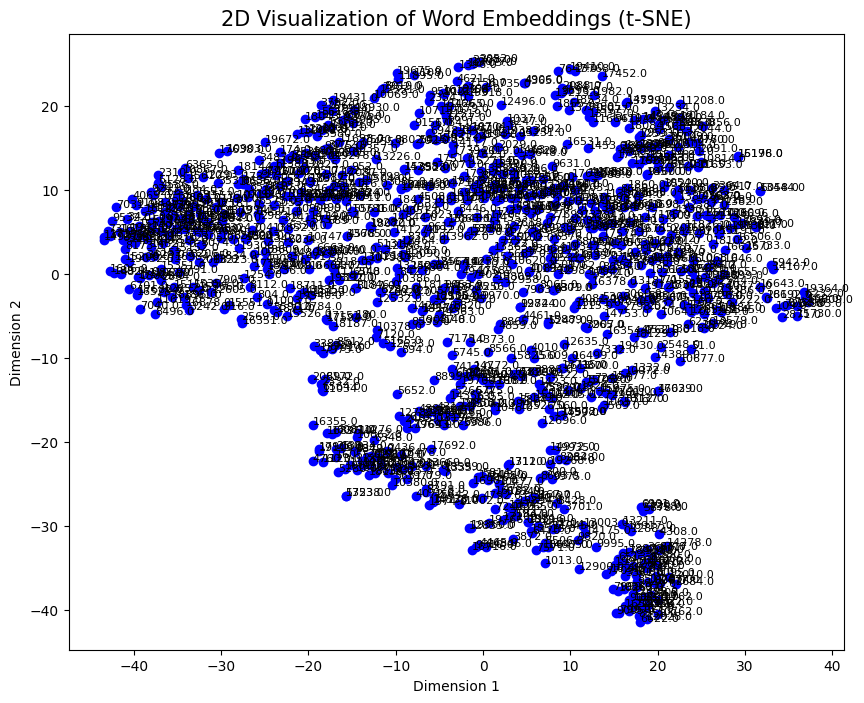


Word: français
Occurrences: 1000
Polysemy score: 0.1016
Review ID 2623.0: [ 0.05529703 -0.05455001  0.05167905 -0.1324541   0.07944793]...
Review ID 19052.0: [ 0.01201788 -0.04843901 -0.21177216 -0.0493848   0.06108226]...
Review ID 4973.0: [-0.01991007 -0.0117149  -0.03103085 -0.04273343  0.07252071]...
Review ID 9284.0: [ 0.06435125 -0.03742328 -0.25510406 -0.0478766   0.06573822]...
Review ID 6247.0: [ 0.04916367  0.07133684 -0.18461625 -0.00186633  0.08441206]...
Review ID 13852.0: [ 0.0830385  -0.0773619  -0.25976795 -0.0765502   0.03389331]...
Review ID 2148.0: [ 0.0655611   0.06548276 -0.19187368 -0.15553994  0.02620807]...
Review ID 1108.0: [ 0.02173703  0.12449552 -0.29960626 -0.03006172  0.04153169]...
Review ID 7604.0: [ 0.07538503  0.10425516 -0.20512074 -0.05324388  0.13026783]...
Review ID 7156.0: [ 0.05470401 -0.02968173 -0.24086891 -0.05905349  0.03975599]...
Review ID 6034.0: [ 0.03126904 -0.14079177 -0.17740677 -0.06906412  0.11638282]...
Review ID 19779.0: [ 0.06646

In [28]:
target_words = ['français']
results = quick_polysemy_analysis(file_path, target_words, sample_size=1000)


Analyzing word: scène


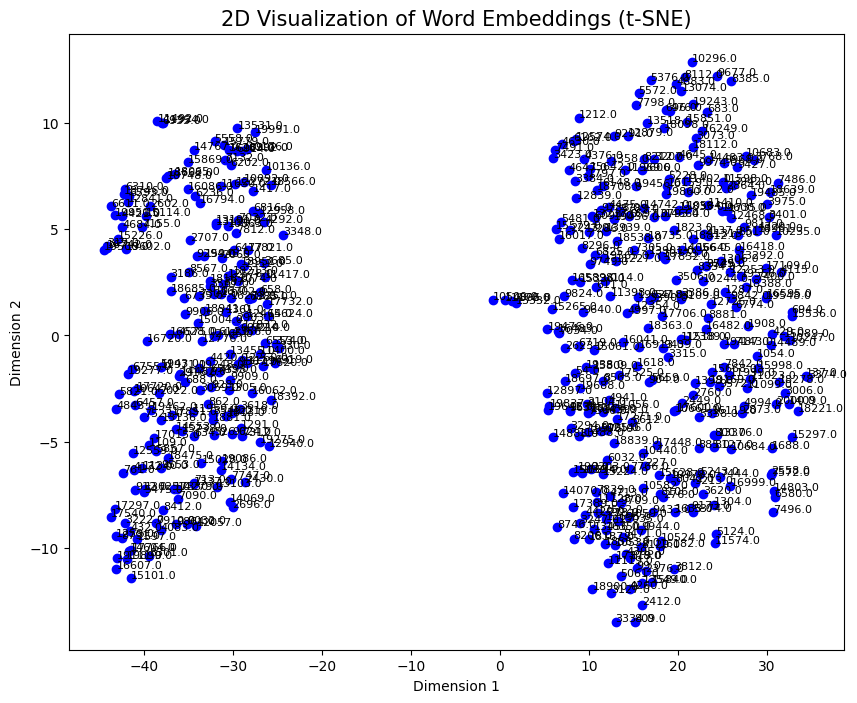


Word: scène
Occurrences: 500
Polysemy score: 0.2068
Review ID 1688.0: [ 0.06677295  0.11250214 -0.2827038  -0.06454395 -0.00475676]...
Review ID 15579.0: [ 0.18494612  0.08774553 -0.3072193   0.08257429 -0.01513079]...
Review ID 5659.0: [ 0.03530813 -0.10160945 -0.38042068 -0.00240866  0.18987286]...
Review ID 12879.0: [ 0.08282787 -0.06773527 -0.23702173  0.02695352 -0.01718043]...
Review ID 7910.0: [-0.02797293  0.28580242 -0.3463641  -0.04521069  0.01975717]...
Review ID 2065.0: [-0.04323471  0.18712446 -0.29931727  0.03175367  0.04706843]...
Review ID 18900.0: [-0.04687994  0.14312449 -0.390408   -0.09078172  0.03961331]...
Review ID 8471.0: [ 0.10646848 -0.17423606 -0.24323052 -0.04769592  0.02226955]...
Review ID 6477.0: [ 0.01646058  0.14227033 -0.22901404  0.11019108  0.02920611]...
Review ID 11574.0: [ 0.04785633  0.09576109 -0.06732987  0.02105306  0.11498975]...
Review ID 7090.0: [-0.05830609  0.11234143 -0.22758408  0.07865654  0.02592501]...
Review ID 4376.0: [ 0.13327318

In [29]:
target_words = ['scène']
results = quick_polysemy_analysis(file_path, target_words, sample_size=500)


Analyzing word: français


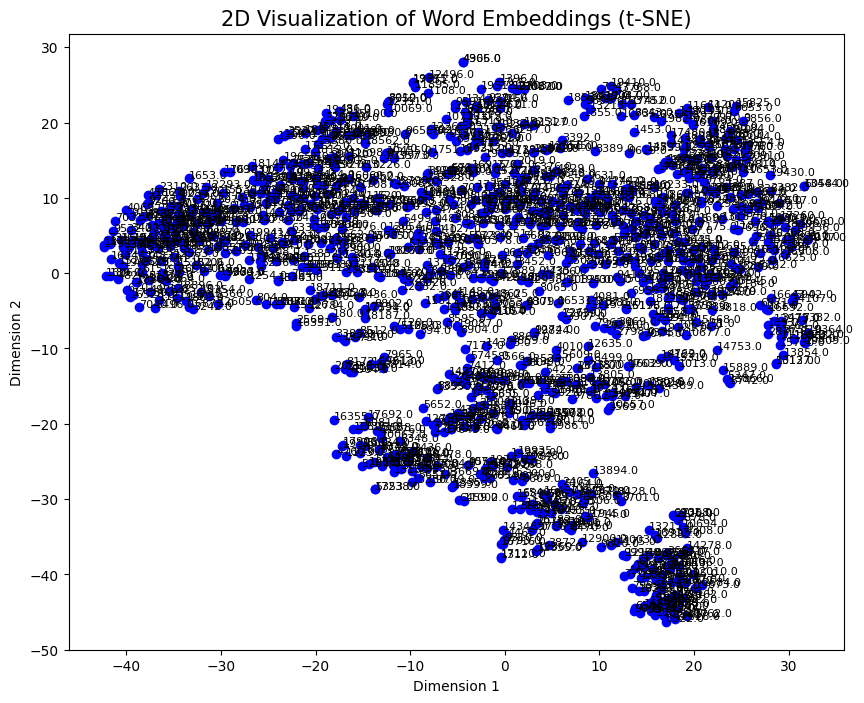


Word: français
Occurrences: 1143
Polysemy score: 0.1000
Review ID 2623.0: [ 0.05529703 -0.05455001  0.05167905 -0.1324541   0.07944793]...
Review ID 19052.0: [ 0.01201788 -0.04843901 -0.21177216 -0.0493848   0.06108226]...
Review ID 4973.0: [-0.01991007 -0.0117149  -0.03103085 -0.04273343  0.07252071]...
Review ID 9284.0: [ 0.06435125 -0.03742328 -0.25510406 -0.0478766   0.06573822]...
Review ID 6247.0: [ 0.04916367  0.07133684 -0.18461625 -0.00186633  0.08441206]...
Review ID 13852.0: [ 0.0830385  -0.0773619  -0.25976795 -0.0765502   0.03389331]...
Review ID 2148.0: [ 0.0655611   0.06548276 -0.19187368 -0.15553994  0.02620807]...
Review ID 1108.0: [ 0.02173703  0.12449552 -0.29960626 -0.03006172  0.04153169]...
Review ID 7604.0: [ 0.07538503  0.10425516 -0.20512074 -0.05324388  0.13026783]...
Review ID 7156.0: [ 0.05470401 -0.02968173 -0.24086891 -0.05905349  0.03975599]...
Review ID 6034.0: [ 0.03126904 -0.14079177 -0.17740677 -0.06906412  0.11638282]...
Review ID 19779.0: [ 0.06646

In [30]:
target_words = ['français']
results = quick_polysemy_analysis(file_path, target_words, sample_size=2000)